In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 26))
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(30, grid_bounds=[(0, 1)])
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_model = GPClassificationModel()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 100))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

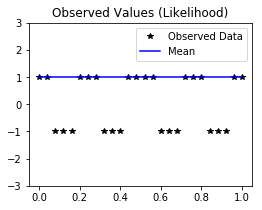

In [6]:
f = plot_model_and_predictions(prior_model, plot_train_data=True)

In [7]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = posterior_model.forward(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        posterior_model.prior_model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()
None

/Users/ruihanwu/playground/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/20 - Loss: 62806.883   log_lengthscale: 0.000
Iter 2/20 - Loss: 49679.234   log_lengthscale: -0.100
Iter 3/20 - Loss: 34333.570   log_lengthscale: -0.199
Iter 4/20 - Loss: 29077.658   log_lengthscale: -0.298
Iter 5/20 - Loss: 22399.316   log_lengthscale: -0.393
Iter 6/20 - Loss: 16085.794   log_lengthscale: -0.489
Iter 7/20 - Loss: 10147.456   log_lengthscale: -0.583
Iter 8/20 - Loss: 8615.176   log_lengthscale: -0.676
Iter 9/20 - Loss: 9358.106   log_lengthscale: -0.772
Iter 10/20 - Loss: 4116.499   log_lengthscale: -0.868
Iter 11/20 - Loss: 3865.708   log_lengthscale: -0.965
Iter 12/20 - Loss: -270.663   log_lengthscale: -1.062
Iter 13/20 - Loss: 5072.482   log_lengthscale: -1.161
Iter 14/20 - Loss: 2449.570   log_lengthscale: -1.262
Iter 15/20 - Loss: 4388.247   log_lengthscale: -1.359
Iter 16/20 - Loss: 4465.408   log_lengthscale: -1.452
Iter 17/20 - Loss: 3180.683   log_lengthscale: -1.544
Iter 18/20 - Loss: 2686.940   log_lengthscale: -1.635
Iter 19/20 - Loss: 1767.302   l

Iter 158/20 - Loss: 24.918   log_lengthscale: -3.679
Iter 159/20 - Loss: 29.918   log_lengthscale: -3.679
Iter 160/20 - Loss: 23.028   log_lengthscale: -3.679
Iter 161/20 - Loss: 12.661   log_lengthscale: -3.678
Iter 162/20 - Loss: 36.360   log_lengthscale: -3.678
Iter 163/20 - Loss: 24.227   log_lengthscale: -3.678
Iter 164/20 - Loss: 21.276   log_lengthscale: -3.678
Iter 165/20 - Loss: 22.022   log_lengthscale: -3.677
Iter 166/20 - Loss: 33.997   log_lengthscale: -3.677
Iter 167/20 - Loss: 25.880   log_lengthscale: -3.677
Iter 168/20 - Loss: 29.335   log_lengthscale: -3.677
Iter 169/20 - Loss: 23.453   log_lengthscale: -3.677
Iter 170/20 - Loss: 11.433   log_lengthscale: -3.676
Iter 171/20 - Loss: 10.557   log_lengthscale: -3.676
Iter 172/20 - Loss: 18.529   log_lengthscale: -3.676
Iter 173/20 - Loss: 21.250   log_lengthscale: -3.675
Iter 174/20 - Loss: 20.852   log_lengthscale: -3.675
Iter 175/20 - Loss: 8.484   log_lengthscale: -3.675
Iter 176/20 - Loss: 28.649   log_lengthscale: -

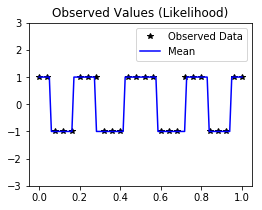

In [8]:
f = plot_model_and_predictions(posterior_model)

In [ ]:
%debug